## Modelo 1

Se cargan las librerías.

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import yaml

Se cargan los datos procesados.

In [22]:
segmentos = []

# Leer los archivos CSV segmentados y almacenarlos en la lista
for i in range(0,3):
    segmento = pd.read_csv(f'../data/processed/segmento_{i+1}.csv')
    segmentos.append(segmento)
# Concatenar los DataFrames de los segmentos en uno solo
df1 = pd.concat(segmentos, ignore_index=True)

Se separa el test del Dataframe original no balanceado para asegurar que los datos nuevos serán similares a los reales a predecir, manteniendo proporción en los datos

In [23]:
# Crear las variables para features y target
X = df1[['amt', 'city_pop', 'distancia', 'fraudes_por_Categoria',
       'fraudes_por_estado', 'fraudes_por_edad', 'fraudes_por_hora',
       'fraudes_por_día']]
y = df1['is_fraud']

# Separamos una muestra del DataFrame para probar el modelo
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state=0, stratify=y)


Una vez obtenido el test, se pasa a balancear los datos, tanto para aligerar la carga del entrenamiento, como para intentar que el modelo prediga mejor la clase minoritaría.

In [7]:
# Aplicamos undersampling a los datos
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# # Separamos el nuevo conjunto en X e y
# X_under = X_resampled
# y_under = y_resampled

Se separa en train y test.

In [64]:
# # Volvemos a separar en test y train para que el test original y los datos del undersample no contaminen a examinar
# X_train_und, X_test_und, y_train_und, y_test_und = train_test_split(X_under,
#                                                    y_under,
#                                                    test_size = 0.2,
#                                                    random_state=0)

Con un GridSearch, se hiperparametriza un GradientBoostingClassifier.

In [65]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", LogisticRegression())
])

# Definir los parámetros del GridSearchCV para regresión logística
lr_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(2, 9),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100, 200, 500],
    'classifier__class_weight': [{0: 100, 1: 1}, {0:50, 1:1}],
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=lr_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1.0, 10.0],
                         'classifier__class_weight': [{0: 100, 1: 1},
                                                      {0: 50, 1: 1}],
                         'classifier__max_iter': [100, 200, 500],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear'],
                         'scaler': [StandardScaler(), None],
                         'selectkbest__k': array([2, 3, 4, 5, 6, 7, 8])},
             scoring='roc_auc')

In [66]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__class_weight': {0: 50, 1: 1},
 'classifier__max_iter': 500,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear',
 'scaler': None,
 'selectkbest__k': 2}

In [67]:
predictions = clf.predict(X_test)

[[128565    352]
 [   466    285]]


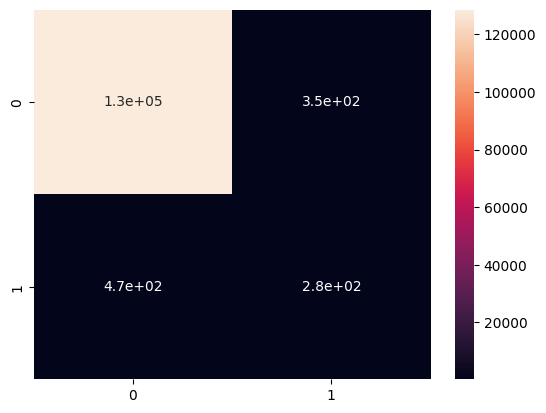

In [68]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [14]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [70]:
precision_score(y_test, predictions)

0.4474097331240188

In [71]:
recall_score(y_test, predictions)

0.3794940079893475

In [72]:
roc_auc_score(y_test, predictions)

0.6883817845123713

In [73]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", LogisticRegression())
])

# Definir los parámetros del GridSearchCV para regresión logística
lr_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(2, 9),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 0.01],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100, 200, 500,1000],
    'classifier__class_weight': [{0: 100, 1: 1}, {0:50, 1:1}],
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=lr_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1.0, 0.01],
                         'classifier__class_weight': [{0: 100, 1: 1},
                                                      {0: 50, 1: 1}],
                         'classifier__max_iter': [100, 200, 500, 1000],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear'],
                         'scaler': [StandardScaler(), None],
                         'selectkbest__k': array([2, 3, 4, 5, 6, 7, 8])},
             scoring='roc_auc')

In [74]:
clf.best_params_

{'classifier__C': 0.01,
 'classifier__class_weight': {0: 100, 1: 1},
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear',
 'scaler': None,
 'selectkbest__k': 2}

In [75]:
predictions = clf.predict(X_test)

[[128681    236]
 [   574    177]]


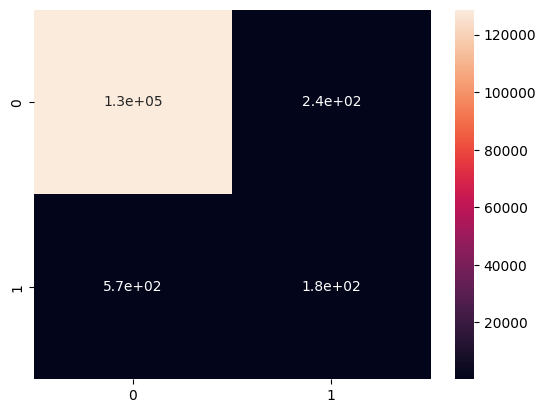

In [76]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [77]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.42857142857142855
Recall score: 0.23568575233022637
ROC AUC score: 0.6169275585576602


Se usa otra estrategia de undersampling y eliminamos class_weight.

In [78]:
# Define las proporciones deseadas para cada clase
sampling_strategy = {
    0: int(0.025 * len(y_train)),
    1: int(0.3 * len(y_train)) if int(0.3 * len(y_train)) <= sum(y_train == 1) else sum(y_train == 1)
}

rus = RandomUnderSampler(random_state=0, sampling_strategy=sampling_strategy)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [79]:
y_resampled.value_counts(normalize=True)

is_fraud
0    0.811996
1    0.188004
Name: proportion, dtype: float64

In [8]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", LogisticRegression())
])

# Definir los parámetros del GridSearchCV para regresión logística
lr_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(2, 9),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 0.01],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100, 200, 500,1000],
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=lr_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits
[CV 1/3; 1/336] START classifier__C=0.1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=2
[CV 1/3; 1/336] END classifier__C=0.1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=2;, score=0.924 total time=   0.0s
[CV 2/3; 1/336] START classifier__C=0.1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=2
[CV 2/3; 1/336] END classifier__C=0.1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=2;, score=0.918 total time=   0.0s
[CV 3/3; 1/336] START classifier__C=0.1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=2
[CV 3/3; 1/336] END classifier__C=0.1, classifier__max_iter

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1.0, 0.01],
                         'classifier__max_iter': [100, 200, 500, 1000],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear'],
                         'scaler': [StandardScaler(), None],
                         'selectkbest__k': array([2, 3, 4, 5, 6, 7, 8])},
             scoring='roc_auc', verbose=10)

In [32]:
predictions = clf.predict(X_test)

In [11]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear',
 'scaler': None,
 'selectkbest__k': 2}

[[112779  16138]
 [   109    642]]


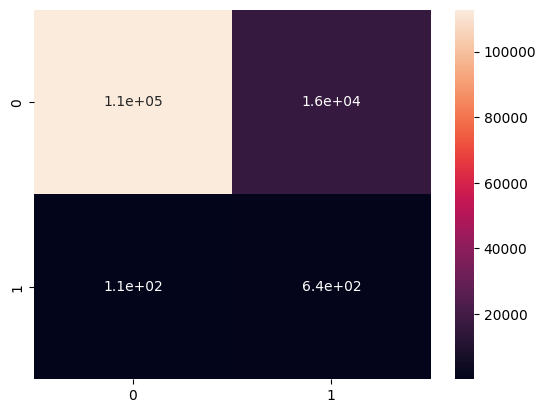

In [12]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [15]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.038259833134684146
Recall score: 0.8548601864181092
ROC AUC score: 0.8648394341028081


In [34]:
# Para escribir el archivo pickle
with open('../models/Model5/trained_model.pkl', 'wb') as archivo_salida:
    pickle.dump(clf.best_estimator_, archivo_salida)

# Para escribir el archivo YAML
with open("../models/Model5/model_config.yaml", "w") as f:
    yaml.dump(clf.best_params_, f)

In [27]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", LogisticRegression())
])

# Definir los parámetros del GridSearchCV para regresión logística
lr_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(3, 7),
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear'],
    'classifier__class_weight': [{0:50, 1:50}]
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=lr_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START classifier__class_weight={0: 50, 1: 50}, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=3
[CV 1/3; 1/8] END classifier__class_weight={0: 50, 1: 50}, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=3;, score=0.903 total time=   1.7s
[CV 2/3; 1/8] START classifier__class_weight={0: 50, 1: 50}, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=3
[CV 2/3; 1/8] END classifier__class_weight={0: 50, 1: 50}, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=3;, score=0.905 total time=   1.6s
[CV 3/3; 1/8] START classifier__class_weight={0: 50, 1: 50}, classifier__penalty=l1, classifier__solver=liblinear, scaler=StandardScaler(), selectkbest__k=3
[CV 3/3; 1/8] END classifier__class_weight={0: 50, 1: 50}, classifier__penalty=l1, classifier

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__class_weight': [{0: 50, 1: 50}],
                         'classifier__penalty': ['l1'],
                         'classifier__solver': ['liblinear'],
                         'scaler': [StandardScaler(), None],
                         'selectkbest__k': array([3, 4, 5, 6])},
             scoring='roc_auc', verbose=10)

In [28]:
predictions = clf.predict(X_test)

[[128866     51]
 [   683     68]]


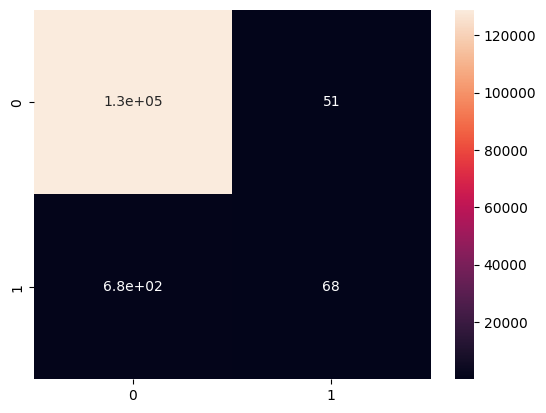

In [29]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [30]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.5714285714285714
Recall score: 0.09054593874833555
ROC AUC score: 0.5450751676878114
